# Import library

In [2]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [4]:
# import packages

import numpy as np 
import pandas as pd 
import json
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
import tensorflow_hub as hub 
import tokenization
import sentencepiece as spm

In [5]:
# If there's a GPU available...
import torch
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Sun Aug 22 18:54:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive
!ls

/content/drive/My Drive
 2019.csv			     model_best_embed_w2c_gru.hdf5
 2019_large.csv			     model_best_embed_w2c.hdf5
'AMLH_assig_4 - 副本.ipynb'	     model_best_embed_w2c_lstm.hdf5
 analyst_ratings_processed.csv	     model_best_gru.hdf5
 analyst_small.csv		     model_best.hdf5
 BERT.csv			     model_best_lstm.hdf5
 BERT_huggingface_tutorial.ipynb     model_best_slstm.hdf5
 CH_BERT.ipynb			     model.h5
 CH_data_0805.csv		     new_0803
 CH_data_2_label.csv		     NewsSentimentAnalysis-master
 CH_data_3_label.csv		     no_label.csv
 chinese_news_0805.csv		     nytimesapi.ipynb
 chinese_news.csv		     __pycache__
 chinese-text-classification.ipynb   Sentences_AllAgree.txt
 choice_news_ustime.csv		     small_data.csv
 code				     SourceHanSansCN-Regular.otf
'Colab Notebooks'		     SourceHanSansCN-VF.otf
 Confusion_matrix_nn.png	    'Test 2.db'
 data				     tokenization.py
 data_0802.csv			     tokenization.py.1
 data_0806.csv			     tokenization.py.10
 data_0806_with_label.csv	     token

# Load data

In [8]:
df = pd.read_csv(r'EN.csv')[['title','label']]
df

,title,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
...,...,...
31614,Battle Over Mink Fur Almost Brings Down the Po...,0
31615,"Travis d’Arnaud, Long an October Footnote, Get...",0
31616,What Polling Tells Us Ahead of the Vice-Presid...,0
31617,2 Men Found Guilty of Aiding 2013 Kenya Mall A...,0


Now check the distribution (ratio) of our target `is_sarcastic`.

In [9]:
df.label.value_counts(normalize=True), df.label.value_counts()

(0    0.532433
 1    0.467567
 Name: label, dtype: float64, 0    16835
 1    14784
 Name: label, dtype: int64)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


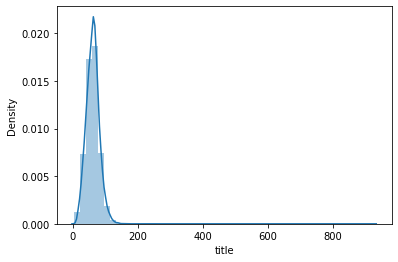

In [10]:
sbs.distplot(df.title.str.len())

In [11]:
print('the max length title is ',max(df.title.str.len()))
print('the min length title is ',min(df.title.str.len()))

the max length title is  926
the min length title is  5


# Models



## Naive Bayes
First step, we should tokenize texts into vectors.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


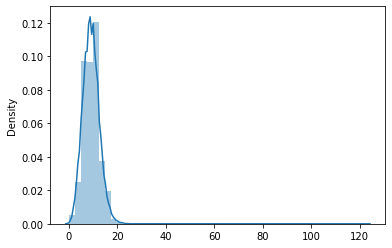

In [12]:
vocab_size = 10000 # max_features 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.title)
train_inputs = tokenizer.texts_to_sequences(df.title)
sbs.distplot([len(l) for l in train_inputs])

See, the above graph confirms our guess: most headline has 5 - 20 words. 


In [13]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=20)
train_labels = df['label']

# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)
train_inputs[0]

array([ 383, 3384, 6823, 2842,    2,  722, 1031,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [14]:
nb = sklearn.naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Validate how the model performs. 


In [15]:
y_preds = nb.predict(X_val)
print(f"Accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print(f"Classification report\n", sklearn.metrics.classification_report(y_val, y_preds))

Accuracy score 0.562618595825427
Classification report
               precision    recall  f1-score   support

           0       0.57      0.76      0.65      3421
           1       0.54      0.33      0.41      2903

    accuracy                           0.56      6324
   macro avg       0.56      0.54      0.53      6324
weighted avg       0.56      0.56      0.54      6324



# Plot Functions

In [16]:

# plot the performace (acc/loss) while training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


In [22]:
# plot ROC curve
def plot_roc(y_label,y_pre):
  fpr, tpr, thersholds = sklearn.metrics.roc_curve(y_label, y_pre)
  
  roc_auc = sklearn.metrics.auc(fpr, tpr)
  
  plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
  
  plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()


In [23]:
def classifaction_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.drop(index=[0])
    return df
 



In [24]:

def plot_cm(labels, predictions, string, p=0.5):
    cm = sklearn.metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(string + ' Confusion matrix p = {:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


In [48]:
def plot_roc_m(true, pred,string):
  fpr, tpr, thersholds = sklearn.metrics.roc_curve(true, pred)
  # for i, value in enumerate(thersholds):
  #     print("%f %f %f" % (fpr[i], tpr[i], value))
  
  roc_auc = sklearn.metrics.auc(fpr, tpr)
  plt.rcParams['lines.linewidth'] = 0.5
  plt.rcParams['lines.linestyle'] = '-'
  plt.plot(fpr, tpr, label=string+'ROC (area = {0:.2f})'.format(roc_auc), lw=1)

Here we consider three different Word Embedding methods

## Keras

Keras has the funtion for word embedding and is easy to use. In Tokenizer() Class One-Hot Encoding method is applied.

### Keras CNN

In [17]:
max_len = 20
text_input_cnn = tf.keras.Input(shape=(max_len, ))
embed_text_cnn = tf.keras.layers.Embedding(vocab_size, 128)(text_input_cnn)

# net_cnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(embed_text_cnn)
net_cnn = tf.keras.layers.GlobalMaxPool1D()(embed_text_cnn)
net_cnn = tf.keras.layers.Dense(32, activation='relu')(net_cnn)
net_cnn = tf.keras.layers.Dropout(0.4)(net_cnn)
# net = tf.keras.layers.Dense(32, activation='relu')(net_lstm)
# net = tf.keras.layers.Dropout(0.4)(net_lstm)

output_cnn = tf.keras.layers.Dense(1, activation='sigmoid')(net_cnn)
model_keras_cnn = tf.keras.models.Model(text_input_cnn, output_cnn)
model_keras_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,284,161
Trainable params: 1,284,161
Non-trainable params: 0
___________________________________________________

In [18]:
model_keras_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_cnn = tf.keras.callbacks.ModelCheckpoint('model_best_cnn.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_cnn = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_cnn = model_keras_cnn.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_cnn, es_cnn], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 3s 6ms/step - loss: 0.6471 - accuracy: 0.6483 - val_loss: 0.5530 - val_accuracy: 0.7881

Epoch 00001: val_accuracy improved from -inf to 0.78814, saving model to model_best_cnn.hdf5
Epoch 2/50
89/89 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.8253 - val_loss: 0.4195 - val_accuracy: 0.8190

Epoch 00002: val_accuracy improved from 0.78814 to 0.81897, saving model to model_best_cnn.hdf5
Epoch 3/50
89/89 [==============================] - 0s 4ms/step - loss: 0.2956 - accuracy: 0.8910 - val_loss: 0.4042 - val_accuracy: 0.8281

Epoch 00003: val_accuracy improved from 0.81897 to 0.82806, saving model to model_best_cnn.hdf5
Epoch 4/50
89/89 [==============================] - 0s 4ms/step - loss: 0.1970 - accuracy: 0.9333 - val_loss: 0.4266 - val_accuracy: 0.8257

Epoch 00004: val_accuracy did not improve from 0.82806
Epoch 5/50
89/89 [==============================] - 0s 4ms/step - loss: 0.1252 - accuracy: 0.963

In [19]:
X_train.shape

(25295, 20)

Plot results

In [20]:
model_keras_cnn = tf.keras.models.load_model('model_best_cnn.hdf5')
y_preds_cnn = model_keras_cnn.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_cnn))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_cnn))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_cnn))

Test accracy score 0.8308032890575585
Test loss  5.843913872675952
Confusion matrix                precision    recall  f1-score   support

           0       0.84      0.85      0.84      3421
           1       0.82      0.81      0.82      2903

    accuracy                           0.83      6324
   macro avg       0.83      0.83      0.83      6324
weighted avg       0.83      0.83      0.83      6324



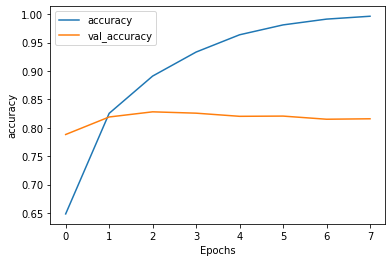

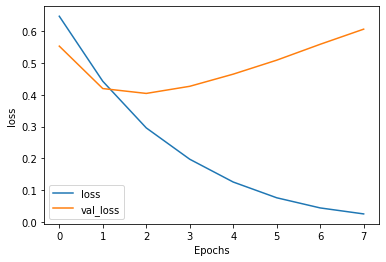

In [21]:
plot_graphs(history_cnn, "accuracy")
plot_graphs(history_cnn, "loss")

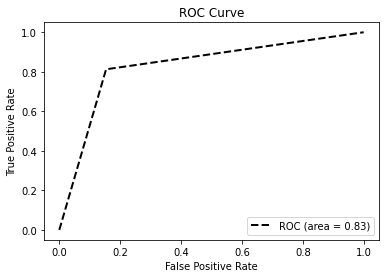

In [25]:
plot_roc(y_val, y_preds_cnn)

### Keras GRU


We consider adding one GRU layer with 32 units after embedding layer.

In [26]:
max_len = 20
text_input_gru = tf.keras.Input(shape=(max_len, ))
embed_text_gru = tf.keras.layers.Embedding(vocab_size, 128)(text_input_gru)

net_gru = tf.keras.layers.GRU(32, return_sequences=True)(embed_text_gru)
net_gru = tf.keras.layers.GlobalMaxPool1D()(net_gru)
net_gru = tf.keras.layers.Dense(32, activation='relu')(net_gru)
net_gru = tf.keras.layers.Dropout(0.4)(net_gru)
# net = tf.keras.layers.Dense(32, activation='relu')(net_lstm)
# net = tf.keras.layers.Dropout(0.4)(net_lstm)

output_gru = tf.keras.layers.Dense(1, activation='sigmoid')(net_gru)
model_keras_gru = tf.keras.models.Model(text_input_gru, output_gru)
model_keras_gru.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 20, 32)            15552     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33  

In [27]:
model_keras_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_gru = tf.keras.callbacks.ModelCheckpoint('model_best_gru.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_gru = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_gru = model_keras_gru.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_gru, es_gru], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 4s 11ms/step - loss: 0.5949 - accuracy: 0.6759 - val_loss: 0.4243 - val_accuracy: 0.8103

Epoch 00001: val_accuracy improved from -inf to 0.81028, saving model to model_best_gru.hdf5
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 0.3616 - accuracy: 0.8568 - val_loss: 0.3979 - val_accuracy: 0.8273

Epoch 00002: val_accuracy improved from 0.81028 to 0.82727, saving model to model_best_gru.hdf5
Epoch 3/50
89/89 [==============================] - 1s 6ms/step - loss: 0.2725 - accuracy: 0.9004 - val_loss: 0.4186 - val_accuracy: 0.8225

Epoch 00003: val_accuracy did not improve from 0.82727
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 0.2212 - accuracy: 0.9229 - val_loss: 0.4597 - val_accuracy: 0.8162

Epoch 00004: val_accuracy did not improve from 0.82727
Epoch 5/50
89/89 [==============================] - 1s 6ms/step - loss: 0.1872 - accuracy: 0.9379 - val_loss: 0.5122 - val_accuracy: 0.8

In [28]:
model_keras_gru = tf.keras.models.load_model('model_best_gru.hdf5')
y_preds_gru = model_keras_gru.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_gru))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_gru))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_gru))

Test accracy score 0.8282732447817837
Test loss  5.931289149732993
Confusion matrix                precision    recall  f1-score   support

           0       0.82      0.87      0.85      3421
           1       0.83      0.78      0.81      2903

    accuracy                           0.83      6324
   macro avg       0.83      0.82      0.83      6324
weighted avg       0.83      0.83      0.83      6324



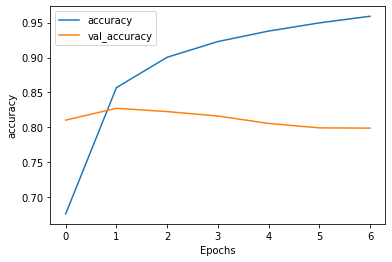

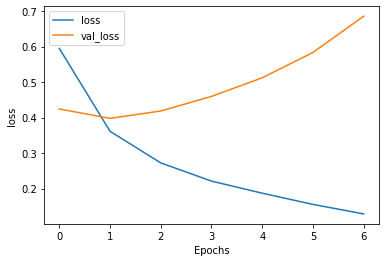

In [29]:
plot_graphs(history_gru, "accuracy")
plot_graphs(history_gru, "loss")

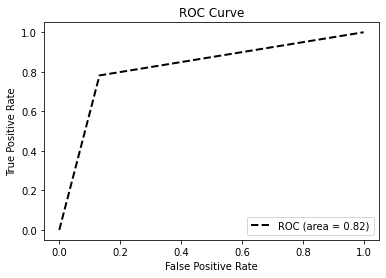

In [30]:
plot_roc(y_val, y_preds_gru)

### Keras LSTM

In [33]:
max_len = 20
text_input_lstm = tf.keras.Input(shape=(max_len, ))
embed_text_lstm = tf.keras.layers.Embedding(vocab_size, 128)(text_input_lstm)

net_lstm = tf.keras.layers.LSTM(32, return_sequences=True)(embed_text_lstm)
net_lstm = tf.keras.layers.GlobalMaxPool1D()(net_lstm)
net_lstm = tf.keras.layers.Dense(32, activation='relu')(net_lstm)
net_lstm = tf.keras.layers.Dropout(0.4)(net_lstm)
# net = tf.keras.layers.Dense(32, activation='relu')(net_lstm)
# net = tf.keras.layers.Dropout(0.4)(net_lstm)

output_lstm = tf.keras.layers.Dense(1, activation='sigmoid')(net_lstm)
model_keras_lstm = tf.keras.models.Model(text_input_lstm, output_lstm)
model_keras_lstm.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 20, 128)           1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 32)            20608     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33  

In [34]:
model_keras_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_lstm = tf.keras.callbacks.ModelCheckpoint('model_best_lstm.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_lstm = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_lstm = model_keras_lstm.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_lstm, es_lstm], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 3s 12ms/step - loss: 0.5667 - accuracy: 0.7037 - val_loss: 0.4121 - val_accuracy: 0.8150

Epoch 00001: val_accuracy improved from -inf to 0.81502, saving model to model_best_lstm.hdf5
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 0.3416 - accuracy: 0.8687 - val_loss: 0.4174 - val_accuracy: 0.8269

Epoch 00002: val_accuracy improved from 0.81502 to 0.82688, saving model to model_best_lstm.hdf5
Epoch 3/50
89/89 [==============================] - 1s 6ms/step - loss: 0.2685 - accuracy: 0.9044 - val_loss: 0.4389 - val_accuracy: 0.8249

Epoch 00003: val_accuracy did not improve from 0.82688
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 0.2274 - accuracy: 0.9204 - val_loss: 0.4666 - val_accuracy: 0.8134

Epoch 00004: val_accuracy did not improve from 0.82688
Epoch 5/50
89/89 [==============================] - 1s 6ms/step - loss: 0.1894 - accuracy: 0.9350 - val_loss: 0.5602 - val_accuracy: 0

In [35]:
model_keras_lstm = tf.keras.models.load_model('model_best_lstm.hdf5')
y_preds_lstm = model_keras_lstm.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_lstm))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_lstm))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_lstm))

Test accracy score 0.8325426944971537
Test loss  5.7838363049448995
Confusion matrix                precision    recall  f1-score   support

           0       0.84      0.85      0.85      3421
           1       0.82      0.81      0.82      2903

    accuracy                           0.83      6324
   macro avg       0.83      0.83      0.83      6324
weighted avg       0.83      0.83      0.83      6324



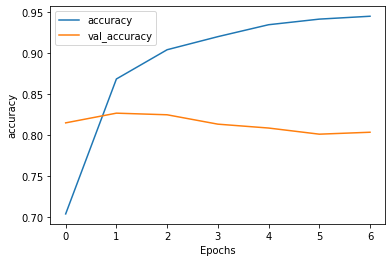

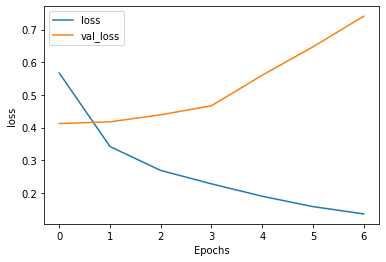

In [36]:
plot_graphs(history_lstm, "accuracy")
plot_graphs(history_lstm, "loss")

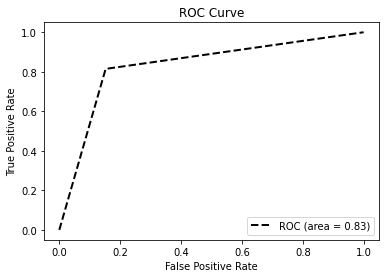

In [37]:
plot_roc(y_val, y_preds_lstm)

### Keras BiLSTM

In [38]:
max_len = 20
text_input_blstm = tf.keras.Input(shape=(max_len, ))
embed_text_blstm = tf.keras.layers.Embedding(vocab_size, 128)(text_input_blstm)

net_blstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embed_text_blstm)
net_blstm = tf.keras.layers.GlobalMaxPool1D()(net_blstm)
net_blstm = tf.keras.layers.Dense(32, activation='relu')(net_blstm)
net_blstm = tf.keras.layers.Dropout(0.4)(net_blstm)
# net = tf.keras.layers.Dense(32, activation='relu')(net_lstm)
# net = tf.keras.layers.Dropout(0.4)(net_lstm)

output_blstm = tf.keras.layers.Dense(1, activation='sigmoid')(net_blstm)
model_keras_blstm = tf.keras.models.Model(text_input_blstm, output_blstm)
model_keras_blstm.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 20, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            41216     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33  

In [39]:
model_keras_blstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_blstm = tf.keras.callbacks.ModelCheckpoint('model_best_blstm.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_blstm = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_blstm = model_keras_lstm.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_blstm, es_blstm], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 2s 12ms/step - loss: 0.2679 - accuracy: 0.9055 - val_loss: 0.4240 - val_accuracy: 0.8162

Epoch 00001: val_accuracy improved from -inf to 0.81621, saving model to model_best_blstm.hdf5
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 0.2280 - accuracy: 0.9202 - val_loss: 0.4667 - val_accuracy: 0.8111

Epoch 00002: val_accuracy did not improve from 0.81621
Epoch 3/50
89/89 [==============================] - 1s 6ms/step - loss: 0.1951 - accuracy: 0.9323 - val_loss: 0.5487 - val_accuracy: 0.8067

Epoch 00003: val_accuracy did not improve from 0.81621
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 0.1664 - accuracy: 0.9407 - val_loss: 0.5938 - val_accuracy: 0.8036

Epoch 00004: val_accuracy did not improve from 0.81621
Epoch 5/50
89/89 [==============================] - 1s 6ms/step - loss: 0.1360 - accuracy: 0.9472 - val_loss: 0.7365 - val_accuracy: 0.8079

Epoch 00005: val_accuracy did not 

In [40]:
model_keras_blstm = tf.keras.models.load_model('model_best_blstm.hdf5')
y_preds_blstm = model_keras_blstm.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_blstm))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_blstm))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_blstm))

Test accracy score 0.8227387729285263
Test loss  6.122457196654886
Confusion matrix                precision    recall  f1-score   support

           0       0.84      0.84      0.84      3421
           1       0.81      0.81      0.81      2903

    accuracy                           0.82      6324
   macro avg       0.82      0.82      0.82      6324
weighted avg       0.82      0.82      0.82      6324



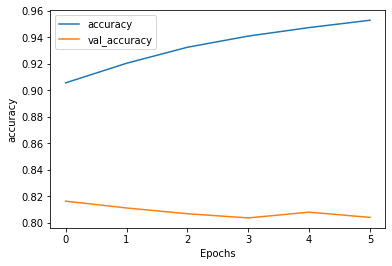

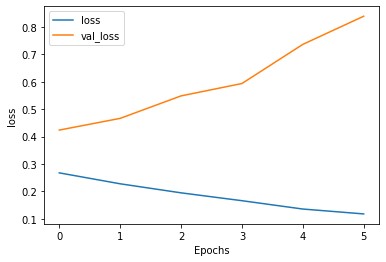

In [41]:
plot_graphs(history_blstm, "accuracy")
plot_graphs(history_blstm, "loss")

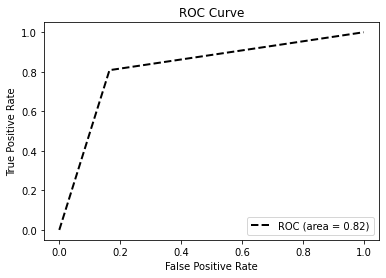

In [42]:
plot_roc(y_val, y_preds_blstm)

### Keras BiGRU

In [43]:
max_len = 20
text_input_bgru = tf.keras.Input(shape=(max_len, ))
embed_text_bgru = tf.keras.layers.Embedding(vocab_size, 128)(text_input_bgru)

net_bgru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(embed_text_bgru)
net_bgru = tf.keras.layers.GlobalMaxPool1D()(net_bgru)
net_bgru = tf.keras.layers.Dense(32, activation='relu')(net_bgru)
net_bgru = tf.keras.layers.Dropout(0.4)(net_bgru)
# net = tf.keras.layers.Dense(32, activation='relu')(net_lstm)
# net = tf.keras.layers.Dropout(0.4)(net_lstm)

output_bgru = tf.keras.layers.Dense(1, activation='sigmoid')(net_bgru)
model_keras_bgru = tf.keras.models.Model(text_input_bgru, output_bgru)
model_keras_bgru.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 20, 128)           1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 64)            31104     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33  

In [44]:
model_keras_bgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_bgru = tf.keras.callbacks.ModelCheckpoint('model_best_bgru.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_bgru = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_bgru = model_keras_bgru.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_bgru, es_bgru], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 5s 16ms/step - loss: 0.5601 - accuracy: 0.7123 - val_loss: 0.4045 - val_accuracy: 0.8257

Epoch 00001: val_accuracy improved from -inf to 0.82569, saving model to model_best_bgru.hdf5
Epoch 2/50
89/89 [==============================] - 1s 8ms/step - loss: 0.3351 - accuracy: 0.8654 - val_loss: 0.4001 - val_accuracy: 0.8281

Epoch 00002: val_accuracy improved from 0.82569 to 0.82806, saving model to model_best_bgru.hdf5
Epoch 3/50
89/89 [==============================] - 1s 8ms/step - loss: 0.2488 - accuracy: 0.9083 - val_loss: 0.4347 - val_accuracy: 0.8221

Epoch 00003: val_accuracy did not improve from 0.82806
Epoch 4/50
89/89 [==============================] - 1s 8ms/step - loss: 0.1926 - accuracy: 0.9329 - val_loss: 0.4768 - val_accuracy: 0.8170

Epoch 00004: val_accuracy did not improve from 0.82806
Epoch 5/50
89/89 [==============================] - 1s 8ms/step - loss: 0.1440 - accuracy: 0.9523 - val_loss: 0.5862 - val_accuracy: 0

In [45]:
model_keras_bgru = tf.keras.models.load_model('model_best_bgru.hdf5')
y_preds_bgru = model_keras_bgru.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_bgru))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_bgru))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_bgru))

Test accracy score 0.8315939278937381
Test loss  5.8166026344244335
Confusion matrix                precision    recall  f1-score   support

           0       0.84      0.85      0.85      3421
           1       0.82      0.80      0.81      2903

    accuracy                           0.83      6324
   macro avg       0.83      0.83      0.83      6324
weighted avg       0.83      0.83      0.83      6324



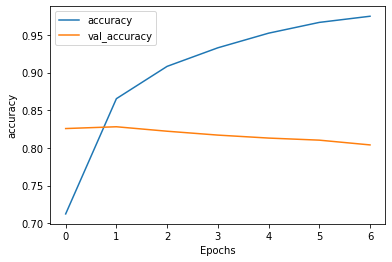

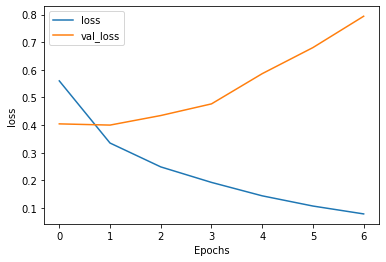

In [46]:
plot_graphs(history_bgru, "accuracy")
plot_graphs(history_bgru, "loss")

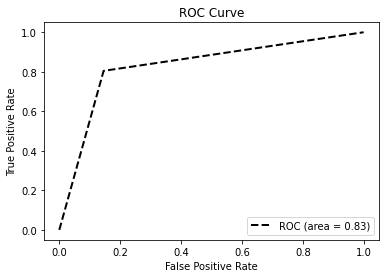

In [47]:
plot_roc(y_val, y_preds_bgru)

### Summary

1. Plot ROC curve together

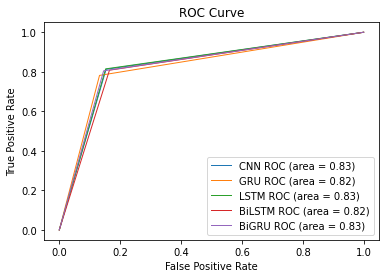

In [50]:
plot_roc_m(y_val, y_preds_cnn,'CNN ')
plot_roc_m(y_val, y_preds_gru,'GRU ')
plot_roc_m(y_val, y_preds_lstm,'LSTM ')
plot_roc_m(y_val, y_preds_blstm,'BiLSTM ')
plot_roc_m(y_val, y_preds_bgru,'BiGRU ')

plt.rcParams['figure.figsize'] = (8.0, 6.0) 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

2. Plot confusion matrix

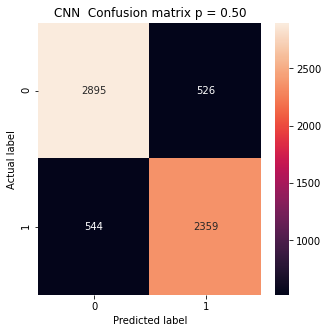

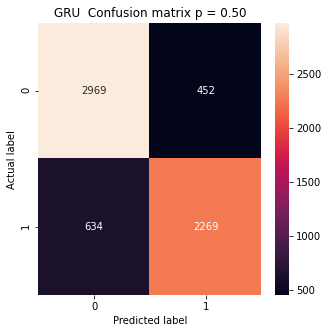

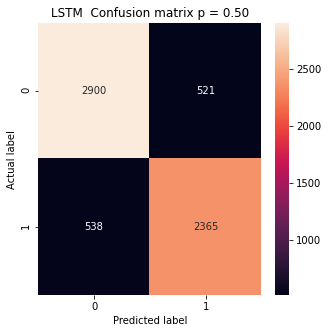

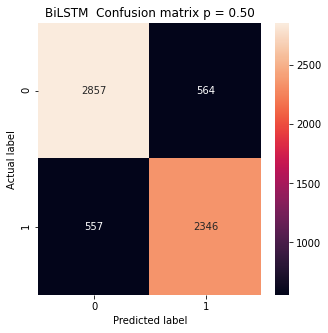

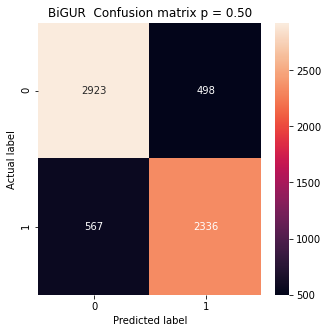

In [51]:
plot_cm(y_val, y_preds_cnn, 'CNN ')
plot_cm(y_val, y_preds_gru, 'GRU ')
plot_cm(y_val, y_preds_lstm,'LSTM ')
plot_cm(y_val, y_preds_blstm,'BiLSTM ')
plot_cm(y_val, y_preds_bgru,'BiGUR ')


,precision,recall,f1-score,support
0,0.835152,0.827828,0.831474,3421.000000
1,0.799182,0.807441,0.803290,2903.000000
accuracy,0.818469,0.818469,0.818469,0.818469
macro avg,0.817167,0.817634,0.817382,6324.000000
weighted avg,0.818640,0.818469,0.818536,6324.000000


In [ ]:
# This part save the classification report for each model to .csv files
# If you want to save those results, please uncomment the codes below.

# report = sklearn.metrics.classification_report(y_val, y_preds_cnn, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("keras_CNN.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_gru, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("keras_GRU.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_slstm, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("keras_LSTM.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_blstm, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("keras_BiLSTM.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_bgru, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("keras_BiGRU.csv", index= True)


## Word2Vec

We now use pretrained wordvector https://code.google.com/archive/p/word2vec/ of Google News (after all, we're dealing with article headlines). 

The vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).

In [52]:
%%time


def embed_word_vector(word_index, pretrained='word2vec-google-news-300'):
    embed_size = 300 # Google news vector is 300-dimensional
    vector = api.load(pretrained)
    zeros = [0] * embed_size
    matrix = np.zeros((vocab_size, embed_size)) 
    
    for word, i in word_index.items():
        if i >= vocab_size or word not in vector: continue 
        matrix[i] = vector[word]
    
    print("Embed word vector completed.")
    return matrix

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.4 µs


Update embedding layer weights of our model

In [53]:
%%time
pretrained = 'glove-wiki-gigaword-300'
matrix = embed_word_vector(tokenizer.word_index, pretrained=pretrained)

[==================================================] 100.0% 376.1/376.1MB downloaded
Embed word vector completed.
CPU times: user 3min 50s, sys: 29.8 s, total: 4min 20s
Wall time: 4min 2s


### Word2Vec CNN

In [54]:
max_len = 20
text_input_w2c = tf.keras.Input(shape=(max_len, ))
embed_text_w2c = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input_w2c)
net_w2c = tf.keras.layers.GlobalMaxPool1D()(embed_text_w2c)
net_w2c = tf.keras.layers.Dense(32, activation='relu')(net_w2c)
net_w2c = tf.keras.layers.Dropout(0.4)(net_w2c)
# net_w2c = tf.keras.layers.Dense(32, activation='relu')(net_w2c)
# net_w2c = tf.keras.layers.Dropout(0.4)(net_w2c)

output_w2c = tf.keras.layers.Dense(1, activation='sigmoid')(net_w2c)
model_w2c = tf.keras.models.Model(text_input_w2c, output_w2c)
model_w2c.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                9632      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 3,009,665
Trainable params: 9,665
Non-trainable params: 3,000,000
_____________________________________________

In [55]:
model_w2c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_w2c = tf.keras.callbacks.ModelCheckpoint('model_best_embed_w2c.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_w2c = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_w2c = model_w2c.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_w2c, es_w2c], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 1s 5ms/step - loss: 0.6888 - accuracy: 0.5453 - val_loss: 0.6725 - val_accuracy: 0.5696

Epoch 00001: val_accuracy improved from -inf to 0.56957, saving model to model_best_embed_w2c.hdf5
Epoch 2/50
89/89 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6118 - val_loss: 0.6344 - val_accuracy: 0.6522

Epoch 00002: val_accuracy improved from 0.56957 to 0.65217, saving model to model_best_embed_w2c.hdf5
Epoch 3/50
89/89 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6455 - val_loss: 0.6131 - val_accuracy: 0.6731

Epoch 00003: val_accuracy improved from 0.65217 to 0.67312, saving model to model_best_embed_w2c.hdf5
Epoch 4/50
89/89 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6657 - val_loss: 0.5962 - val_accuracy: 0.6949

Epoch 00004: val_accuracy improved from 0.67312 to 0.69486, saving model to model_best_embed_w2c.hdf5
Epoch 5/50
89/89 [=============

In [56]:
model_w2c = tf.keras.models.load_model('model_best_embed_w2c.hdf5')
y_preds_w2c = model_w2c.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_w2c))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_w2c))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_w2c))

Test accracy score 0.7197975964579381
Test loss  9.677955634028685
Confusion matrix                precision    recall  f1-score   support

           0       0.74      0.75      0.74      3421
           1       0.70      0.68      0.69      2903

    accuracy                           0.72      6324
   macro avg       0.72      0.72      0.72      6324
weighted avg       0.72      0.72      0.72      6324



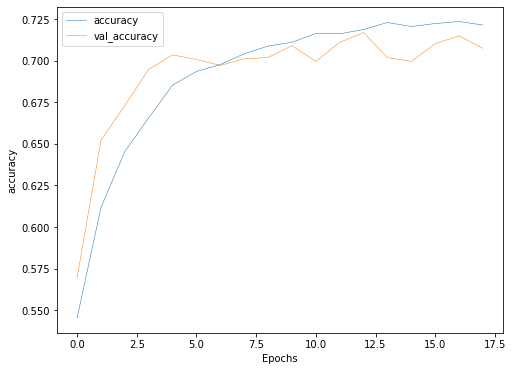

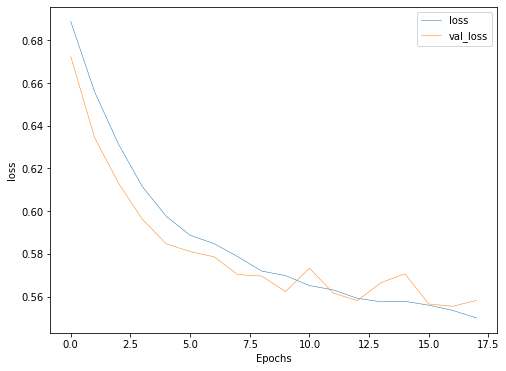

In [57]:
plot_graphs(history_w2c, "accuracy")
plot_graphs(history_w2c, "loss")

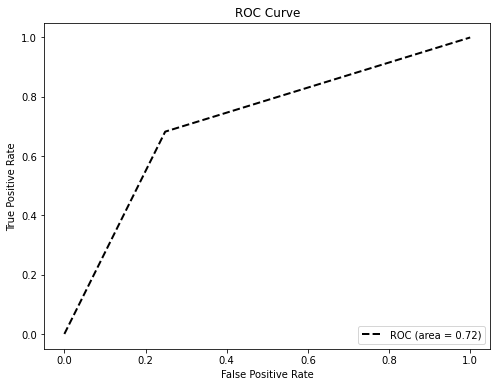

In [58]:
plot_roc(y_val, y_preds_w2c)

### Word2Vec LSTM


In [59]:
max_len = 20
text_input_w2c_lstm = tf.keras.Input(shape=(max_len, ))
embed_text_w2c_lstm = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input_w2c_lstm)

net_w2c_lstm = tf.keras.layers.LSTM(32, return_sequences=True)(embed_text_w2c_lstm)
net_w2c_lstm = tf.keras.layers.GlobalMaxPool1D()(net_w2c_lstm)
net_w2c_lstm = tf.keras.layers.Dense(32, activation='relu')(net_w2c_lstm)
net_w2c_lstm = tf.keras.layers.Dropout(0.4)(net_w2c_lstm)
# net_w2c = tf.keras.layers.Dense(32, activation='relu')(net_w2c)
# net_w2c = tf.keras.layers.Dropout(0.4)(net_w2c)

output_w2c_lstm = tf.keras.layers.Dense(1, activation='sigmoid')(net_w2c_lstm)
model_w2c_lstm = tf.keras.models.Model(text_input_w2c_lstm, output_w2c_lstm)
model_w2c_lstm.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 32)            42624     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33  

Re run our model to see if any improvements we got.

In [60]:
model_w2c_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_w2c_lstm = tf.keras.callbacks.ModelCheckpoint('model_best_embed_w2c_lstm.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_w2c_lstm = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_w2c_lstm = model_w2c_lstm.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_w2c_lstm, es_w2c_lstm], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 3s 11ms/step - loss: 0.6176 - accuracy: 0.6586 - val_loss: 0.5238 - val_accuracy: 0.7478

Epoch 00001: val_accuracy improved from -inf to 0.74783, saving model to model_best_embed_w2c_lstm.hdf5
Epoch 2/50
89/89 [==============================] - 0s 5ms/step - loss: 0.4874 - accuracy: 0.7764 - val_loss: 0.4697 - val_accuracy: 0.7850

Epoch 00002: val_accuracy improved from 0.74783 to 0.78498, saving model to model_best_embed_w2c_lstm.hdf5
Epoch 3/50
89/89 [==============================] - 0s 5ms/step - loss: 0.4295 - accuracy: 0.8120 - val_loss: 0.4389 - val_accuracy: 0.7988

Epoch 00003: val_accuracy improved from 0.78498 to 0.79881, saving model to model_best_embed_w2c_lstm.hdf5
Epoch 4/50
89/89 [==============================] - 0s 5ms/step - loss: 0.3974 - accuracy: 0.8317 - val_loss: 0.4343 - val_accuracy: 0.8032

Epoch 00004: val_accuracy improved from 0.79881 to 0.80316, saving model to model_best_embed_w2c_lstm.hdf5
Epoch 5/50

In [61]:
model_w2c_lstm = tf.keras.models.load_model('model_best_embed_w2c_lstm.hdf5')
y_preds_w2c_lstm = model_w2c_lstm.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_w2c_lstm))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_w2c_lstm))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_w2c_lstm))

Test accracy score 0.8263757115749526
Test loss  5.996834578986249
Confusion matrix                precision    recall  f1-score   support

           0       0.83      0.85      0.84      3421
           1       0.82      0.80      0.81      2903

    accuracy                           0.83      6324
   macro avg       0.83      0.82      0.82      6324
weighted avg       0.83      0.83      0.83      6324



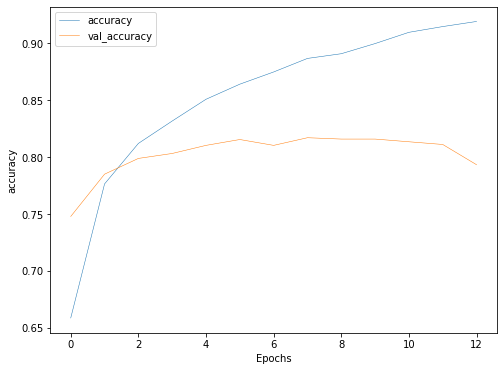

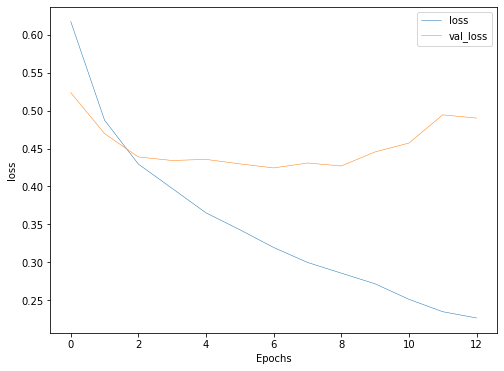

In [62]:
plot_graphs(history_w2c_lstm, "accuracy")
plot_graphs(history_w2c_lstm, "loss")

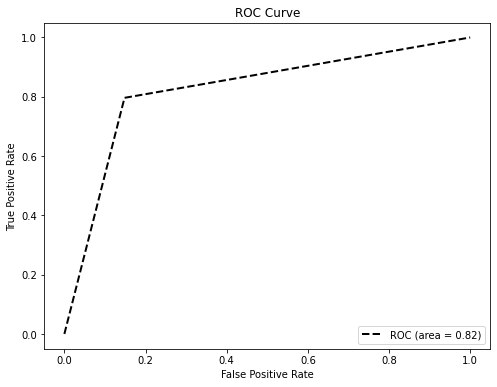

In [63]:
plot_roc(y_val, y_preds_w2c_lstm)

### Word2Vec GRU

In [64]:
max_len = 20
text_input_w2c_gru = tf.keras.Input(shape=(max_len, ))
embed_text_w2c_gru = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input_w2c_gru)

net_w2c_gru = tf.keras.layers.GRU(32, return_sequences=True)(embed_text_w2c_gru)
net_w2c_gru = tf.keras.layers.GlobalMaxPool1D()(net_w2c_gru)
net_w2c_gru = tf.keras.layers.Dense(32, activation='relu')(net_w2c_gru)
net_w2c_gru = tf.keras.layers.Dropout(0.4)(net_w2c_gru)
# net_w2c = tf.keras.layers.Dense(32, activation='relu')(net_w2c)
# net_w2c = tf.keras.layers.Dropout(0.4)(net_w2c)

output_w2c_gru = tf.keras.layers.Dense(1, activation='sigmoid')(net_w2c_gru)
model_w2c_gru = tf.keras.models.Model(text_input_w2c_gru, output_w2c_gru)
model_w2c_gru.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 32)            32064     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33  

Re run our model to see if any improvements we got.

In [65]:
model_w2c_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_w2c_gru = tf.keras.callbacks.ModelCheckpoint('model_best_embed_w2c_gru.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_w2c_gru = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_w2c_gru = model_w2c_gru.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_w2c_gru, es_w2c_gru], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 3s 10ms/step - loss: 0.6438 - accuracy: 0.6260 - val_loss: 0.5476 - val_accuracy: 0.7439

Epoch 00001: val_accuracy improved from -inf to 0.74387, saving model to model_best_embed_w2c_gru.hdf5
Epoch 2/50
89/89 [==============================] - 0s 5ms/step - loss: 0.5017 - accuracy: 0.7648 - val_loss: 0.4714 - val_accuracy: 0.7822

Epoch 00002: val_accuracy improved from 0.74387 to 0.78221, saving model to model_best_embed_w2c_gru.hdf5
Epoch 3/50
89/89 [==============================] - 0s 5ms/step - loss: 0.4421 - accuracy: 0.8015 - val_loss: 0.4448 - val_accuracy: 0.7937

Epoch 00003: val_accuracy improved from 0.78221 to 0.79368, saving model to model_best_embed_w2c_gru.hdf5
Epoch 4/50
89/89 [==============================] - 0s 5ms/step - loss: 0.4094 - accuracy: 0.8226 - val_loss: 0.4311 - val_accuracy: 0.8040

Epoch 00004: val_accuracy improved from 0.79368 to 0.80395, saving model to model_best_embed_w2c_gru.hdf5
Epoch 5/50
89/

In [66]:
model_w2c_gru = tf.keras.models.load_model('model_best_embed_w2c_gru.hdf5')
y_preds_w2c_gru = model_w2c_gru.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_w2c_gru))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_w2c_gru))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_w2c_gru))

Test accracy score 0.8162555344718533
Test loss  6.346393343196103
Confusion matrix                precision    recall  f1-score   support

           0       0.85      0.81      0.83      3421
           1       0.78      0.83      0.81      2903

    accuracy                           0.82      6324
   macro avg       0.82      0.82      0.82      6324
weighted avg       0.82      0.82      0.82      6324



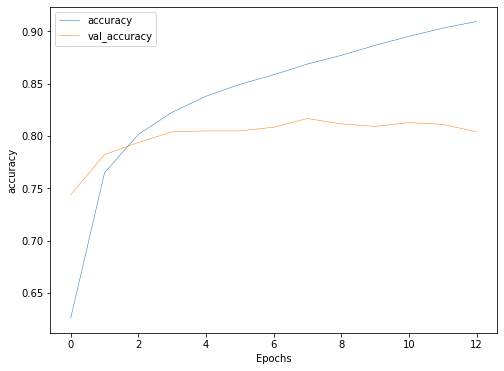

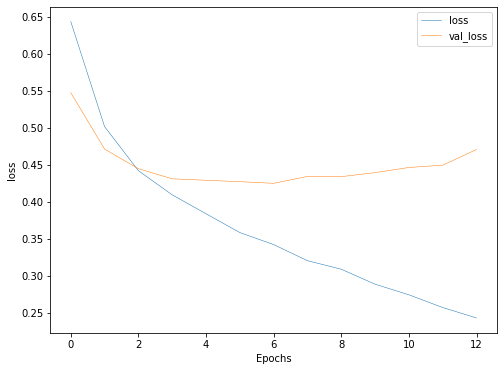

In [67]:
plot_graphs(history_w2c_gru, "accuracy")
plot_graphs(history_w2c_gru, "loss")

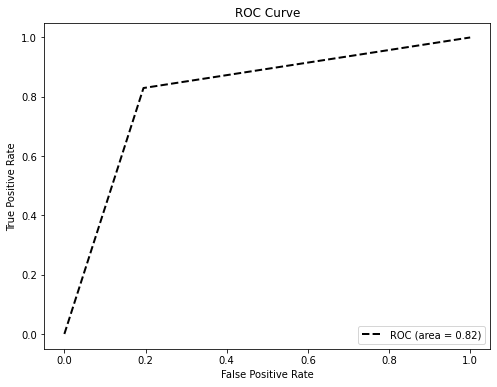

In [69]:
plot_roc(y_val, y_preds_w2c_gru)

### Word2Vec BiLSTM

In [70]:
max_len = 20
text_input_w2c_blstm = tf.keras.Input(shape=(max_len, ))
embed_text_w2c_blstm = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input_w2c_blstm)

net_w2c_blstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embed_text_w2c_blstm)
net_w2c_blstm = tf.keras.layers.GlobalMaxPool1D()(net_w2c_blstm)
net_w2c_blstm = tf.keras.layers.Dense(32, activation='relu')(net_w2c_blstm)
net_w2c_blstm = tf.keras.layers.Dropout(0.4)(net_w2c_blstm)
# net_w2c = tf.keras.layers.Dense(32, activation='relu')(net_w2c)
# net_w2c = tf.keras.layers.Dropout(0.4)(net_w2c)

output_w2c_blstm = tf.keras.layers.Dense(1, activation='sigmoid')(net_w2c_blstm)
model_w2c_blstm = tf.keras.models.Model(text_input_w2c_blstm, output_w2c_blstm)
model_w2c_blstm.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 64)            85248     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33  

Re run our model to see if any improvements we got.

In [71]:
model_w2c_blstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_w2c_blstm = tf.keras.callbacks.ModelCheckpoint('model_best_embed_w2c_blstm.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_w2c_blstm = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_w2c_blstm = model_w2c_blstm.fit(X_train, y_train,
                    epochs=50, batch_size=256, callbacks=[mc_w2c_blstm, es_w2c_blstm], 
                    validation_split=0.1, verbose=1)

Epoch 1/50
89/89 [==============================] - 5s 16ms/step - loss: 0.5987 - accuracy: 0.6798 - val_loss: 0.5026 - val_accuracy: 0.7668

Epoch 00001: val_accuracy improved from -inf to 0.76680, saving model to model_best_embed_w2c_blstm.hdf5
Epoch 2/50
89/89 [==============================] - 1s 8ms/step - loss: 0.4643 - accuracy: 0.7940 - val_loss: 0.4545 - val_accuracy: 0.7964

Epoch 00002: val_accuracy improved from 0.76680 to 0.79644, saving model to model_best_embed_w2c_blstm.hdf5
Epoch 3/50
89/89 [==============================] - 1s 8ms/step - loss: 0.4085 - accuracy: 0.8237 - val_loss: 0.4356 - val_accuracy: 0.8036

Epoch 00003: val_accuracy improved from 0.79644 to 0.80356, saving model to model_best_embed_w2c_blstm.hdf5
Epoch 4/50
89/89 [==============================] - 1s 8ms/step - loss: 0.3704 - accuracy: 0.8458 - val_loss: 0.4272 - val_accuracy: 0.8083

Epoch 00004: val_accuracy improved from 0.80356 to 0.80830, saving model to model_best_embed_w2c_blstm.hdf5
Epoch 

In [72]:
model_w2c_blstm = tf.keras.models.load_model('model_best_embed_w2c_blstm.hdf5')
y_preds_w2c_blstm = model_w2c_blstm.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_w2c_blstm))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_w2c_blstm))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_w2c_blstm))

Test accracy score 0.8262175838077166
Test loss  6.002288785144371
Confusion matrix                precision    recall  f1-score   support

           0       0.82      0.87      0.84      3421
           1       0.83      0.78      0.80      2903

    accuracy                           0.83      6324
   macro avg       0.83      0.82      0.82      6324
weighted avg       0.83      0.83      0.83      6324



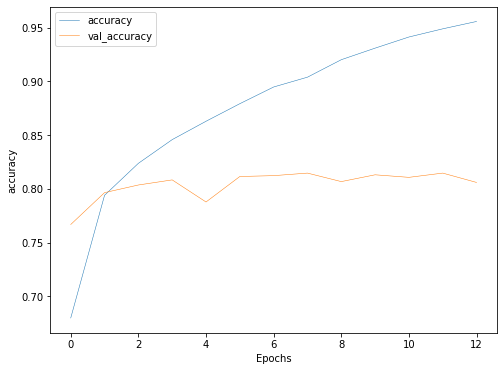

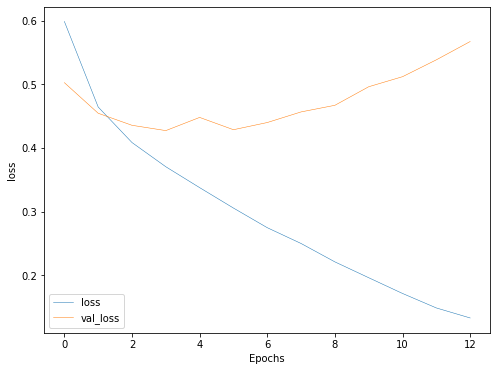

In [73]:
plot_graphs(history_w2c_blstm, "accuracy")
plot_graphs(history_w2c_blstm, "loss")

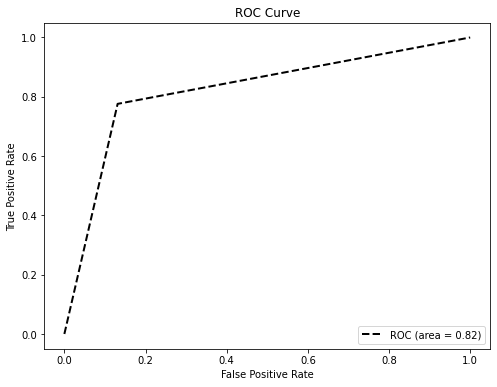

In [74]:
plot_roc(y_val, y_preds_w2c_blstm)

### Word2Vec BiGRU

In [75]:
max_len = 20
text_input_w2c_bgru = tf.keras.Input(shape=(max_len, ))
embed_text_w2c_bgru = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input_w2c_bgru)

net_w2c_bgru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(embed_text_w2c_bgru)
net_w2c_bgru = tf.keras.layers.GlobalMaxPool1D()(net_w2c_bgru)
net_w2c_bgru = tf.keras.layers.Dense(32, activation='relu')(net_w2c_bgru)
net_w2c_bgru = tf.keras.layers.Dropout(0.4)(net_w2c_bgru)
# net_w2c = tf.keras.layers.Dense(32, activation='relu')(net_w2c)
# net_w2c = tf.keras.layers.Dropout(0.4)(net_w2c)

output_w2c_bgru = tf.keras.layers.Dense(1, activation='sigmoid')(net_w2c_bgru)
model_w2c_bgru = tf.keras.models.Model(text_input_w2c_bgru, output_w2c_bgru)
model_w2c_bgru.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 20, 300)           3000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 64)            64128     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33 

Re run our model to see if any improvements we got.

In [76]:
model_w2c_bgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc_w2c_bgru = tf.keras.callbacks.ModelCheckpoint('model_best_embed_w2c_bgru.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es_w2c_bgru= tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history_w2c_bgru = model_w2c_bgru.fit(X_train, y_train,
                    epochs=20, batch_size=256, callbacks=[mc_w2c_bgru, es_w2c_bgru], 
                    validation_split=0.1, verbose=1)

Epoch 1/20
89/89 [==============================] - 5s 19ms/step - loss: 0.6106 - accuracy: 0.6649 - val_loss: 0.5190 - val_accuracy: 0.7510

Epoch 00001: val_accuracy improved from -inf to 0.75099, saving model to model_best_embed_w2c_bgru.hdf5
Epoch 2/20
89/89 [==============================] - 1s 7ms/step - loss: 0.4860 - accuracy: 0.7767 - val_loss: 0.4617 - val_accuracy: 0.7866

Epoch 00002: val_accuracy improved from 0.75099 to 0.78656, saving model to model_best_embed_w2c_bgru.hdf5
Epoch 3/20
89/89 [==============================] - 1s 7ms/step - loss: 0.4279 - accuracy: 0.8116 - val_loss: 0.4531 - val_accuracy: 0.7905

Epoch 00003: val_accuracy improved from 0.78656 to 0.79051, saving model to model_best_embed_w2c_bgru.hdf5
Epoch 4/20
89/89 [==============================] - 1s 7ms/step - loss: 0.3903 - accuracy: 0.8348 - val_loss: 0.4251 - val_accuracy: 0.8099

Epoch 00004: val_accuracy improved from 0.79051 to 0.80988, saving model to model_best_embed_w2c_bgru.hdf5
Epoch 5/20

In [77]:
model_w2c_bgru = tf.keras.models.load_model('model_best_embed_w2c_bgru.hdf5')
y_preds_w2c_bgru = model_w2c_bgru.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds_w2c_bgru))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_w2c_bgru))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_w2c_bgru))

Test accracy score 0.8197343453510436
Test loss  6.226219874143333
Confusion matrix                precision    recall  f1-score   support

           0       0.82      0.85      0.84      3421
           1       0.82      0.78      0.80      2903

    accuracy                           0.82      6324
   macro avg       0.82      0.82      0.82      6324
weighted avg       0.82      0.82      0.82      6324



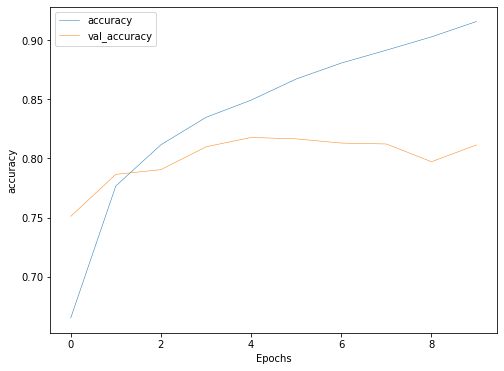

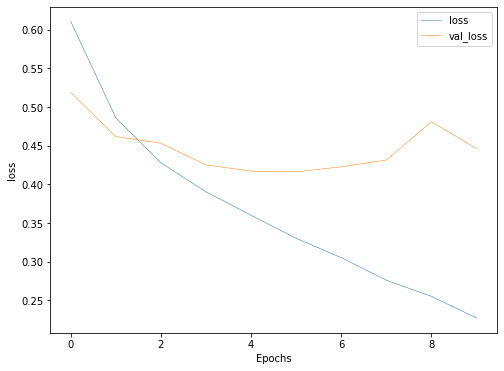

In [78]:
plot_graphs(history_w2c_bgru, "accuracy")
plot_graphs(history_w2c_bgru, "loss")

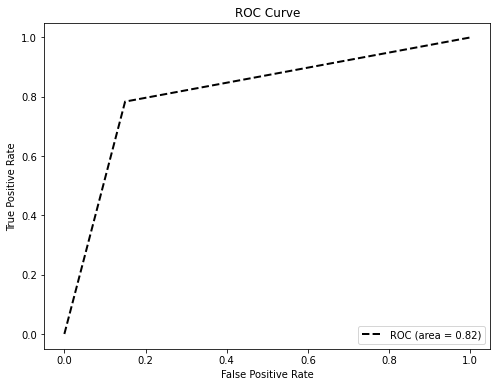

In [79]:
plot_roc(y_val, y_preds_w2c_bgru)

### Summary

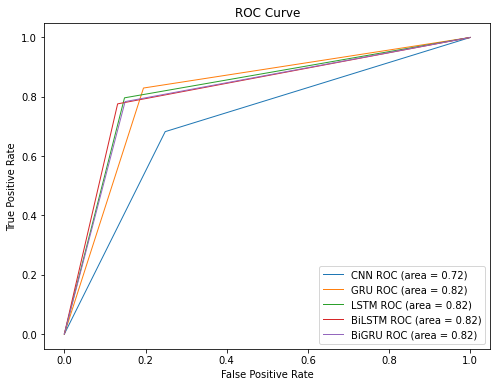

In [80]:
plot_roc_m(y_val, y_preds_w2c,'CNN ')
plot_roc_m(y_val, y_preds_w2c_gru,'GRU ')
plot_roc_m(y_val, y_preds_w2c_lstm,'LSTM ')
plot_roc_m(y_val, y_preds_w2c_blstm,'BiLSTM ')
plot_roc_m(y_val, y_preds_w2c_bgru,'BiGRU ')

plt.rcParams['figure.figsize'] = (8.0, 6.0) 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

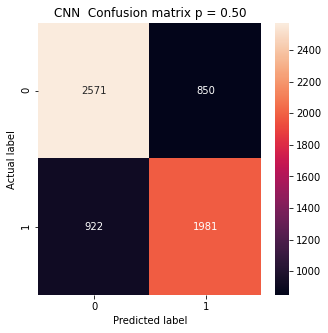

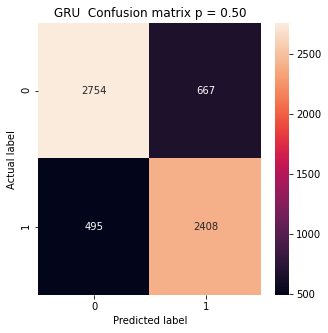

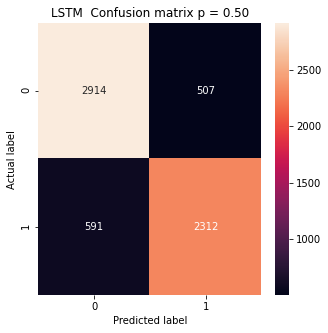

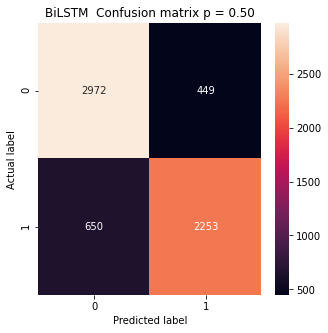

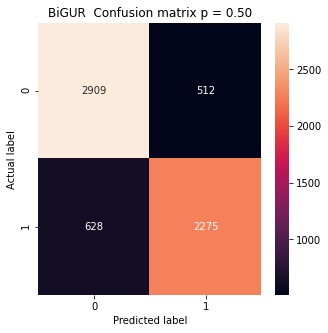

In [81]:
plot_cm(y_val, y_preds_w2c, 'CNN ')
plot_cm(y_val, y_preds_w2c_gru, 'GRU ')
plot_cm(y_val, y_preds_w2c_lstm,'LSTM ')
plot_cm(y_val, y_preds_w2c_blstm,'BiLSTM ')
plot_cm(y_val, y_preds_w2c_bgru,'BiGUR ')

In [82]:
# This part save the classification report for each model to .csv files
# If you want to save those results, please uncomment the codes below.

# report = sklearn.metrics.classification_report(y_val, y_preds_w2c, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("w2c_CNN.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_w2c_gru, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("w2c_GRU.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_w2c_lstm, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("w2c_LSTM.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_w2c_blstm, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("w2c_BiLSTM.csv", index= True)
# report = sklearn.metrics.classification_report(y_val, y_preds_w2c_bgru, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("w2c_BiGRU.csv", index= True)

## BERT

In [83]:
%%time
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 10.4 s, sys: 1.8 s, total: 12.2 s
Wall time: 12 s


In [84]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [85]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(32, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    # net = tf.keras.layers.Dense(32, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Remember in previous sections, we have explored on the headline length. Most of them has a length between 50 to 150, and the majority has a length of 70. We set the length to 120.

In [86]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.title, df['label'], 
                                                                          test_size=0.1, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

Let's build the model and train on it.

In [87]:
model_bert = build_model(bert_layer, max_len=100)
model_bert.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [88]:
%%time
checkpoint_bert = tf.keras.callbacks.ModelCheckpoint('model_bert.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping_bert = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

history_bert = model_bert.fit(
    X_train, y_train, 
    validation_split=0.1,
    epochs=10,
    callbacks=[checkpoint_bert, earlystopping_bert],
    batch_size=16,
    verbose=1
)

Epoch 1/10
1601/1601 [==============================] - 356s 213ms/step - loss: 0.3555 - accuracy: 0.8476 - val_loss: 0.2759 - val_accuracy: 0.8837

Epoch 00001: val_accuracy improved from -inf to 0.88370, saving model to model_bert.h5
Epoch 2/10
1601/1601 [==============================] - 341s 213ms/step - loss: 0.2124 - accuracy: 0.9160 - val_loss: 0.2728 - val_accuracy: 0.8914

Epoch 00002: val_accuracy improved from 0.88370 to 0.89143, saving model to model_bert.h5
Epoch 3/10
1601/1601 [==============================] - 341s 213ms/step - loss: 0.1355 - accuracy: 0.9441 - val_loss: 0.3525 - val_accuracy: 0.8879

Epoch 00003: val_accuracy did not improve from 0.89143
Epoch 4/10
1601/1601 [==============================] - 340s 213ms/step - loss: 0.0895 - accuracy: 0.9633 - val_loss: 0.3963 - val_accuracy: 0.8826

Epoch 00004: val_accuracy did not improve from 0.89143
Epoch 5/10
1601/1601 [==============================] - 340s 213ms/step - loss: 0.0611 - accuracy: 0.9751 - val_loss:

In [89]:
%%time
model_bert.load_weights('model_bert.h5')
y_preds_bert = model_bert.predict(X_val).round().astype(int)
print("Validation accuracy: ", sklearn.metrics.accuracy_score(y_val, y_preds_bert))
print("Test loss ", sklearn.metrics.log_loss(y_val, y_preds_bert))
print("Confusion matrix ", sklearn.metrics.classification_report(y_val, y_preds_bert))

Validation accuracy:  0.8984819734345351
Test loss  3.5063390177278255
Confusion matrix                precision    recall  f1-score   support

           0       0.89      0.93      0.91      1740
           1       0.91      0.86      0.88      1422

    accuracy                           0.90      3162
   macro avg       0.90      0.89      0.90      3162
weighted avg       0.90      0.90      0.90      3162

CPU times: user 3.08 s, sys: 857 ms, total: 3.94 s
Wall time: 16.1 s


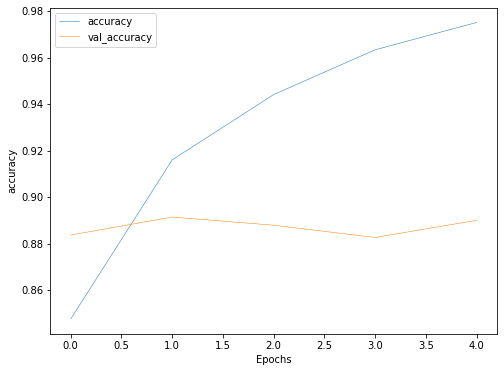

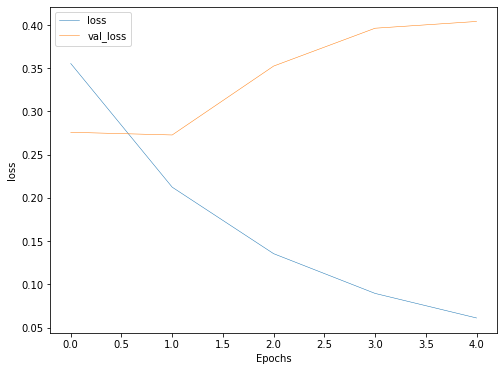

In [90]:
plot_graphs(history_bert, "accuracy")
plot_graphs(history_bert, "loss")

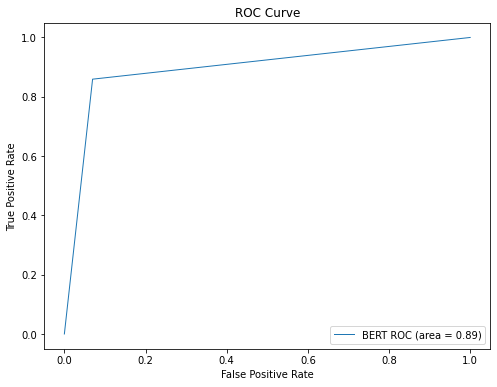

In [91]:
plot_roc_m(y_val,y_preds_bert,'BERT ')
plt.rcParams['figure.figsize'] = (8.0, 6.0) 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

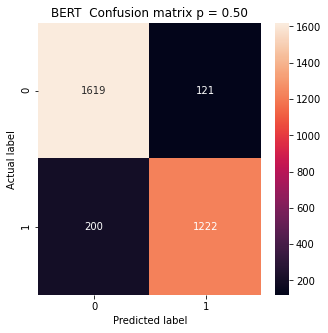

In [92]:
plot_cm(y_val, y_preds_bert,'BERT ')

In [ ]:
# This part save the classification report for each model to .csv files
# If you want to save those results, please uncomment the codes below.
# report = sklearn.metrics.classification_report(y_val, y_preds_bert, output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report.to_csv("BERT.csv", index= True)


The result can be further improved by: 
1. increasing the length of `max_len`, i.e., the length of input headline length 
2. fine-tuning parameters 
3. trying other pretrained bert modules.

To summarize, BERT is definitely the winner of text classification tasks.

# Plot

In [93]:
results = pd.read_csv(r'results.csv',index_col = 0)


In [94]:
results

,precision,recall,f1-score,accuracy
keras_CNN,0.829088,0.828841,0.828960,0.830171
keras_LSTM,0.811812,0.811909,0.811860,0.813093
keras_GRU,0.835246,0.827299,0.829435,0.832226
keras_BiLSTM,0.821607,0.818904,0.819905,0.821790
keras_BiGRU,0.833050,0.833632,0.833314,0.834282
word2vec_CNN,0.817167,0.817634,0.817382,0.818469
word2vec_LSTM,0.816857,0.818020,0.817293,0.818153
word2vec_GRU,0.823134,0.821665,0.822278,0.823846
word2vec_BiLSTM,0.822051,0.821915,0.821982,0.823213
word2vec_BiGRU,0.818944,0.816461,0.817396,0.819260


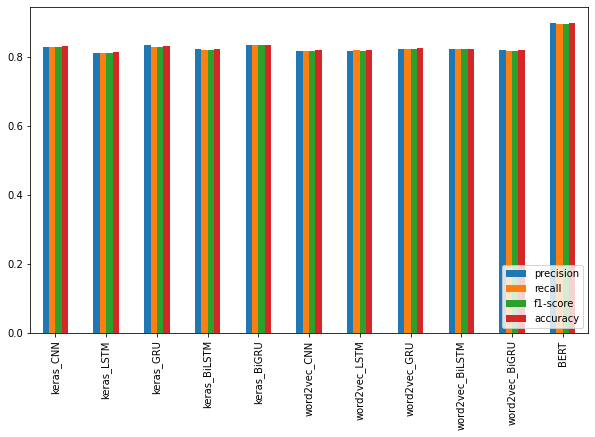

In [95]:
ax = results.plot(kind='bar',figsize =(10,6))
ax.legend(loc='lower right') 
plt.show()


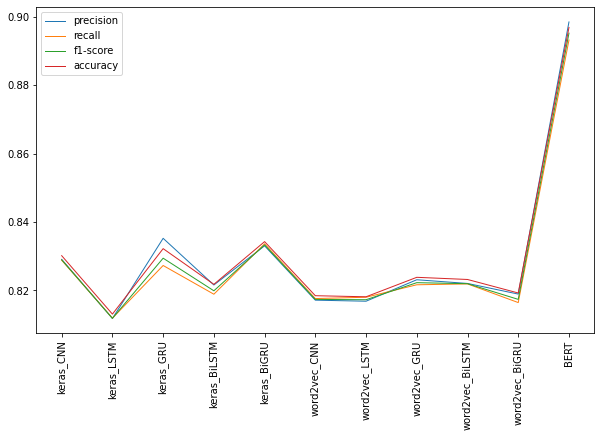

In [96]:
index_ls = results.index.tolist()
scale_ls = range(11)
ax = results.plot(kind='line',lw = 1,figsize =(10,6))
plt.xticks(scale_ls,index_ls)
plt.xticks(rotation=90)
ax.legend(loc='upper left') 
# plt.figure(figsize=(10,6))
# plt.title('Classification Report')
# plt.legend()
plt.show()

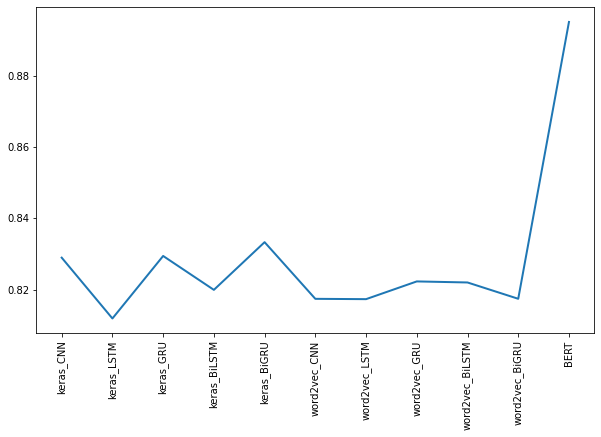

In [98]:
f1_score = results['f1-score']
ax = f1_score.plot(kind='line',lw = 2,figsize =(10,6))
plt.xticks(scale_ls,index_ls)
plt.xticks(rotation=90)
plt.show()

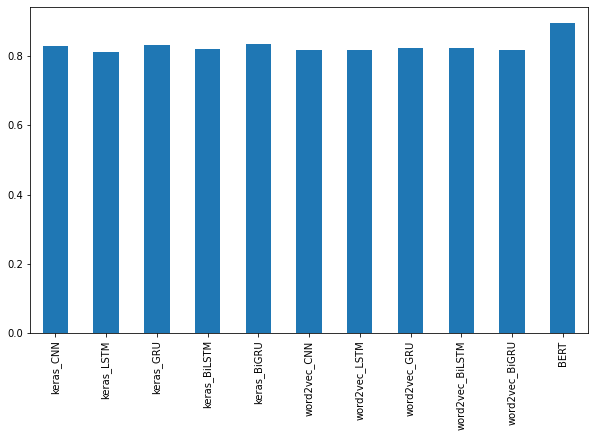

In [99]:
ax = f1_score.plot(kind='bar',figsize =(10,6))
plt.show()

In [101]:
results_with_label = pd.read_csv(r'results_with_label.csv',index_col = 0)
results_with_label

,0,1
keras_CNN,0.843349,0.814572
keras_LSTM,0.827092,0.796628
keras_GRU,0.851255,0.807616
keras_BiLSTM,0.838330,0.801480
keras_BiGRU,0.846018,0.820609
word2vec_CNN,0.831474,0.803290
word2vec_LSTM,0.829831,0.804754
word2vec_GRU,0.838971,0.805585
word2vec_BiLSTM,0.836788,0.807175
word2vec_BiGRU,0.835847,0.798945


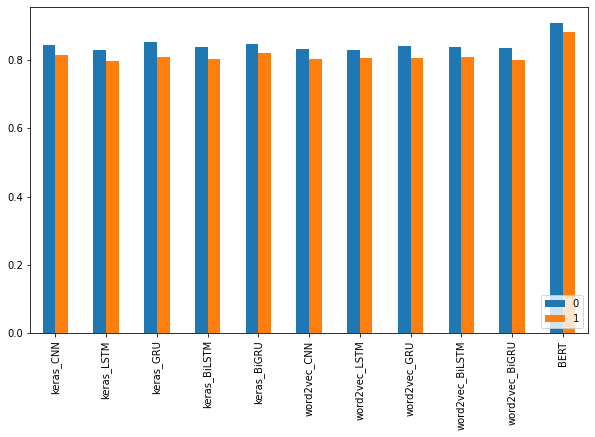

In [102]:
ax = results_with_label.plot(kind='bar',figsize =(10,6))
ax.legend(loc='lower right') 
plt.show()

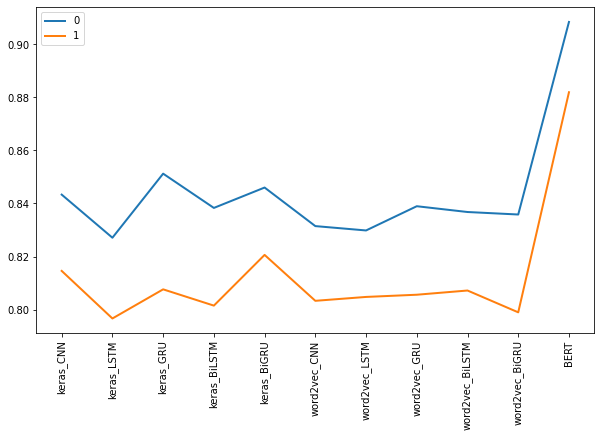

In [104]:
ax = results_with_label.plot(kind='line',lw = 2,figsize =(10,6))
plt.xticks(scale_ls,index_ls)
plt.xticks(rotation=90)
ax.legend(loc='upper left') 
plt.show()